In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from pathlib import Path
import numpy as np

import torch
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule
from turboflow.evaluation import compute_all_metrics
from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch

import matplotlib.pyplot as plt

In [3]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

In [12]:
# load dataset for TRAIN
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm_train = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=int(8*(32*32)),
                         time_idx=np.arange(4),
                         train_downsampling_space=8,
                         val_downsampling_space=8,
                         test_downsampling_space=8,
                         
                         train_downsampling_time=4,
                         val_downsampling_time=4,
                         test_downsampling_time=4,
                         
                         train_shuffle=False,
                         val_shuffle=False,
                         test_shuffle=False,
                         num_workers=1)
dm_train.setup(stage='fit')

datasets = [dm_train.train_dataset, dm_train.val_dataset]

for dataset in datasets:

    X, y = dataset[:]
    print(X.shape, y.shape, dataset.img_res, dataset.vars_shape_img)

torch.Size([1024, 3]) torch.Size([1024, 2]) 32 (1, 32, 32, 3)
torch.Size([1024, 3]) torch.Size([1024, 2]) 32 (1, 32, 32, 3)


In [28]:
from turboflow.models.phyrff import plDivFreeRFFNet

# choose the hyperparams
hparams = {
    'name':'RFFNet',
    'do_time' : True,
    'mlp_layers_num': 6,
    'mlp_layers_dim': 256, 
    'mlp_last_actfn': 'tanh',
    'rff_num_space': 256, 
    'rff_scale_space': 10,
    'rff_num_time': 64, 
    'rff_scale_time': 10,
    'do_divfree': False,
    'lam_sdiv': 0,     # spatial grad(u,v) = torch.autograd(u,v)
    'lam_sfn':  0,     # offgrid L2 reg. on Sfun
    'lam_spec': 0,     # L2 diff on the spectrum
    'lam_grads':1e-3,     # offrgid L2 reg. on grad and autograd
    'lam_curl' :0,     # smooth grad of vorticity
    'lam_pde' : 0,
    'lam_weight': 0,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

model = plDivFreeRFFNet(**vars(Namespace(**hparams)))

early_stop_callback = EarlyStopping(monitor='val/loss/tot')
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss/tot",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-{epoch:02d}-{val_loss:.2f}" % (hparams['name']),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1,
                  max_epochs=3000, 
                  log_every_n_steps=5,
                  check_val_every_n_epoch=20, 
                  callbacks=[early_stop_callback,
                             checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [29]:
trainer.fit(model, dm_train)

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | rff_time   | Fourier         | 64    
1 | rff_space  | Fourier         | 512   
2 | proj_time  | MLP             | 16.5 K
3 | proj_space | MLP             | 65.7 K
4 | gmlp_time  | gMLP            | 176 K 
5 | gmlp_space | gMLP            | 88.1 K
6 | mlp        | MLP             | 18.7 K
7 | mlp_last   | MLP             | 66    
8 | sp_grad    | SpatialGradient | 0     
9 | sp_lapl    | Laplacian       | 0     
-----------------------------------------------
365 K     Trainable params
576       Non-trainable params
365 K     Total para

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [30]:
# setup dataset for TEST
# TEST spatial super-resolution
dm_test_space = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=int(1024),
                         time_idx=np.arange(8*8),
                         train_downsampling_space=8,
                         val_downsampling_space=4,
                         test_downsampling_space=2,
                         train_downsampling_time=8,
                         val_downsampling_time=8,
                         test_downsampling_time=8,
                         train_shuffle=False,
                         val_shuffle=False,
                         test_shuffle=False,
                         num_workers=1)
dm_test_space.setup()

# TEST spatial temporal-resolution
dm_test_time = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=int(1024),
                         time_idx=np.arange(8*8),
                         train_downsampling_space=8,
                         val_downsampling_space=8,
                         test_downsampling_space=8,
                         train_downsampling_time=4,
                         val_downsampling_time=2,
                         test_downsampling_time=1,
                         train_shuffle=False,
                         val_shuffle=False,
                         test_shuffle=False,
                         num_workers=1)
dm_test_time.setup()

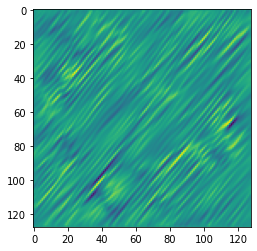

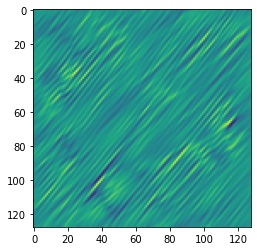

In [33]:
datasets = dm_test_space.test_dataset

X, y = dataset[:]
img_shape = dataset.img_shape
vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

X.requires_grad_(True)
y_hat, P_hat = model(X)

model.eval()
y_img_hat = y_hat.view(*fshape).permute(0,3,1,2)[None,2,...]

grads = model.sp_grad(y_img_hat)
du_x_spat = grads[:,0,1,...].squeeze()
du_y_spat = grads[:,0,0,...].squeeze()
dv_x_spat = grads[:,1,1,...].squeeze()
dv_y_spat = grads[:,1,0,...].squeeze()

plt.imshow(du_x_spat.detach())
plt.show()


## Navier Stokes loss (vorticity equation)
U, V = torch.split(y_hat, 1, -1)

dU = tch.diff(U, X)
U_t, U_x, U_y = dU.split(1, -1)

plt.imshow(U_x.view(*fshape[:3])[2,:,:].detach())
plt.show()

# dV = tch.diff(V, X)
# V_x, V_y, V_t = dV.split(1, -1)

# W = V_x - U_y

# w = phy.compute_vorticity([txy[t,:,:,1], txy[t,:,:,2]],
#                           [uv[t,:,:,0], uv[t,:,:,1]])
# w_hat = phy.compute_vorticity([txy[t,:,:,1], txy[t,:,:,2]],
#                               [uv_hat[t,:,:,0], uv_hat[t,:,:,1]])
# w_auto = W.reshape(vshape[:-1]).detach().cpu().numpy()[t,:,:]

torch.Size([8192, 3]) torch.Size([8192, 2]) -> (8, 32, 32, 3) (8, 32, 32, 2)


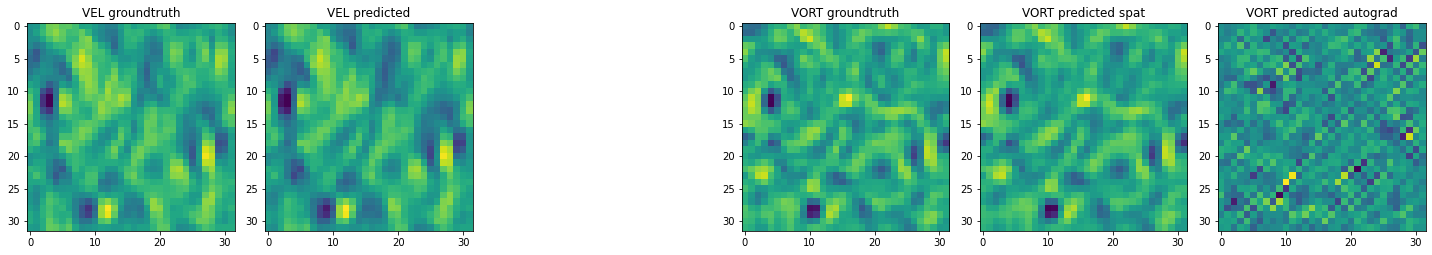

torch.Size([32768, 3]) torch.Size([32768, 2]) -> (8, 64, 64, 3) (8, 64, 64, 2)


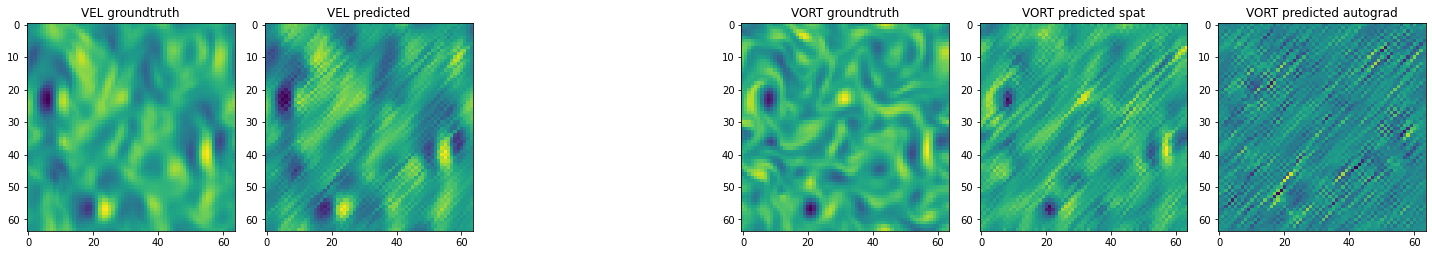

torch.Size([131072, 3]) torch.Size([131072, 2]) -> (8, 128, 128, 3) (8, 128, 128, 2)


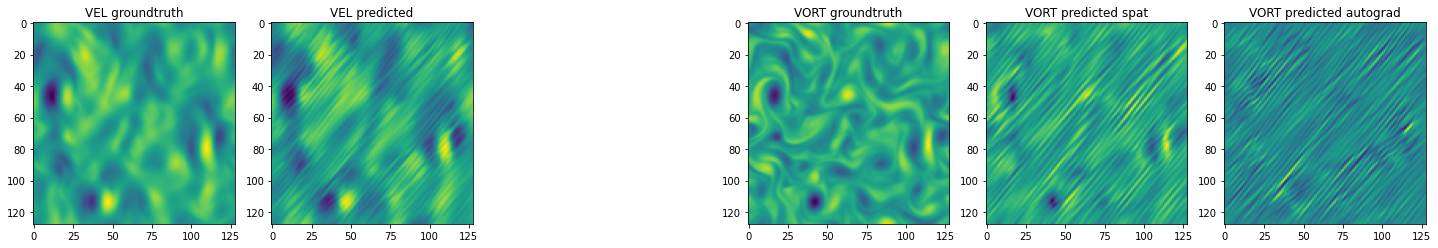

In [32]:
datasets = [dm_test_space.train_dataset, dm_test_space.val_dataset, dm_test_space.test_dataset]

for dataset in datasets:

    X, y = dataset[:]
    img_shape = dataset.img_shape
    vshape = dataset.vars_shape_img
    fshape = dataset.fields_shape_img

    X.requires_grad_(True)
    y_hat, P_hat = model(X)
    txy = X.reshape(*vshape).detach().cpu().numpy()

    uv = y.reshape(*fshape).detach().cpu().numpy()
    uv_hat = y_hat.reshape(*fshape).detach().cpu().numpy()
    
    print(X.shape, y.shape, '->', txy.shape, uv_hat.shape)
    
    t = 0
    
    # # Navier Stokes loss (vorticity equation)
    U, V = torch.split(y_hat, 1, -1)

    dU = tch.diff(U, X)
    U_x, U_y, U_t = dU.split(1, -1)

    dV = tch.diff(V, X)
    V_x, V_y, V_t = dV.split(1, -1)
    
    W = V_x - U_y
        
    w = phy.compute_vorticity([txy[t,:,:,1], txy[t,:,:,2]],
                              [uv[t,:,:,0], uv[t,:,:,1]])
    w_hat = phy.compute_vorticity([txy[t,:,:,1], txy[t,:,:,2]],
                                  [uv_hat[t,:,:,0], uv_hat[t,:,:,1]])
    w_auto = W.reshape(vshape[:-1]).detach().cpu().numpy()[t,:,:]

    plt.figure(figsize=(20,5))
    plt.subplot(161)
    plt.title('VEL groundtruth')
    plt.imshow(uv[t,:,:,0])
    plt.subplot(162)
    plt.title('VEL predicted')
    plt.imshow(uv_hat[t,:,:,0])
    plt.subplot(164)
    plt.title('VORT groundtruth')
    plt.imshow(w)
    plt.subplot(165)
    plt.title('VORT predicted spat')
    plt.imshow(w_hat)
    plt.subplot(166)
    plt.title('VORT predicted autograd')
    plt.imshow(w_auto)
    plt.tight_layout()
    plt.show()

torch.Size([16384, 3]) torch.Size([16384, 2]) -> (16, 32, 32, 3) (16, 32, 32, 2)


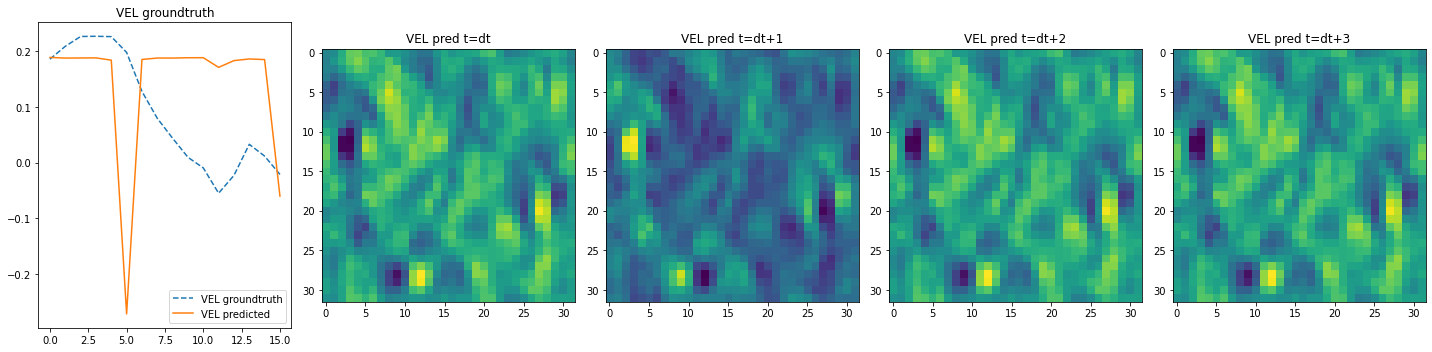

torch.Size([32768, 3]) torch.Size([32768, 2]) -> (32, 32, 32, 3) (32, 32, 32, 2)


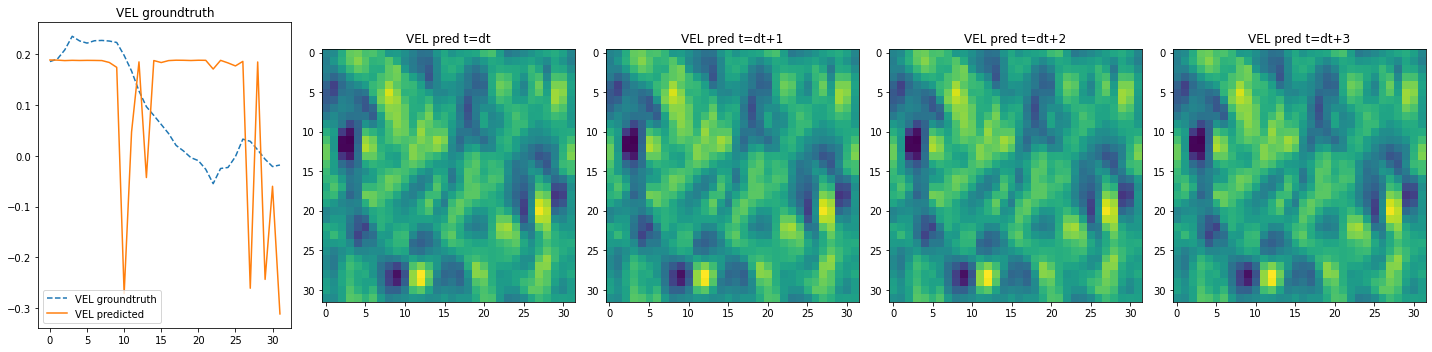

torch.Size([65536, 3]) torch.Size([65536, 2]) -> (64, 32, 32, 3) (64, 32, 32, 2)


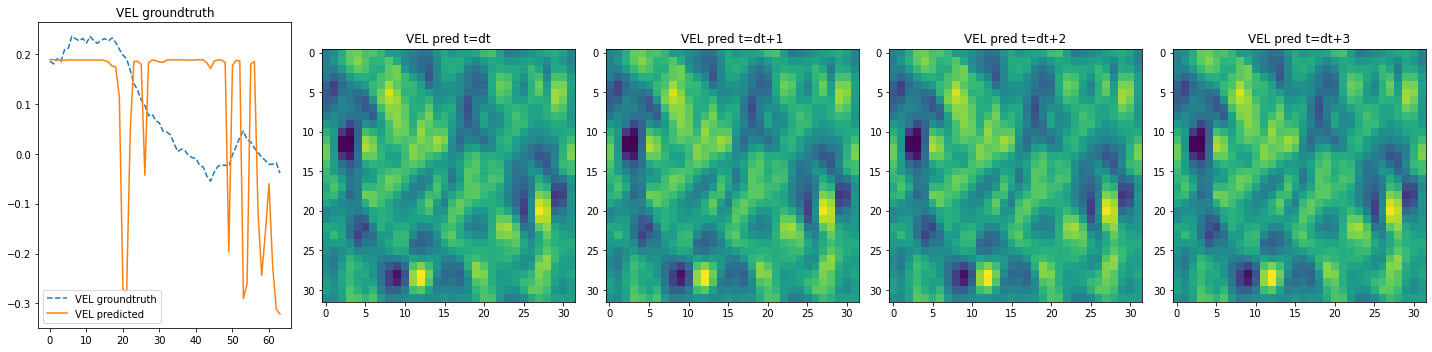

In [25]:
datasets = [dm_test_time.train_dataset, dm_test_time.val_dataset, dm_test_time.test_dataset]

for dataset in datasets:

    X, y = dataset[:]
    img_shape = dataset.img_shape
    vshape = dataset.vars_shape_img
    fshape = dataset.fields_shape_img

    model.eval()
    X.requires_grad_(True)
    y_hat, P_hat = model(X)
    txy = X.reshape(*vshape).detach().cpu().numpy()

    uv = y.reshape(*fshape).detach().cpu().numpy()
    uv_hat = y_hat.reshape(*fshape).detach().cpu().numpy()
    
    print(X.shape, y.shape, '->', txy.shape, uv_hat.shape)
    
    i = 22
    j = 16
    
    # # Navier Stokes loss (vorticity equation)
    U, V = torch.split(y_hat, 1, -1)

    dU = tch.diff(U, X)
    U_x, U_y, U_t = dU.split(1, -1)

    dV = tch.diff(V, X)
    V_x, V_y, V_t = dV.split(1, -1)
    
    W = V_x - U_y
        
    w_auto = W.reshape(vshape[:-1]).detach().cpu().numpy()

    plt.figure(figsize=(20,5))
    plt.subplot(151)
    plt.title('VEL groundtruth')
    plt.plot(uv[:,i,j,0], '--', label='VEL groundtruth')
    plt.plot(uv_hat[:,i,j,0], label='VEL predicted')
    plt.legend()
    
    plt.subplot(152)
    plt.title('VEL pred t=dt')
    plt.imshow(uv_hat[4,:,:,0])
    plt.subplot(153)
    plt.title('VEL pred t=dt+1')
    plt.imshow(uv_hat[5,:,:,0])
    plt.subplot(154)
    plt.title('VEL pred t=dt+2')
    plt.imshow(uv_hat[6,:,:,0])
    plt.subplot(155)
    plt.title('VEL pred t=dt+3')
    plt.imshow(uv_hat[7,:,:,0])
    plt.tight_layout()
    plt.show()

In [ ]:
dataset = dm_train.train_dataset

X, y = dataset[:]
img_shape = dataset.img_shape
vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

print(X.shape)
print(y.shape)

y_hat, P_hat = model(X)
X = X.reshape(*vshape).detach().cpu().numpy()
y_hat = y_hat.reshape(*fshape).detach().cpu().numpy()
y = y.reshape(*fshape).detach().cpu().numpy()

print(P_hat)
print(y.shape)
print(y_hat.shape)

In [ ]:
# ds = 1
# for i in range(0,20):
#     a = X.reshape(*vshape)[i,:,:,1]
#     b = X.reshape(*vshape)[i,:,:,2]
#     u = y.reshape(*fshape)[i,:,:,0]
#     v = y.reshape(*fshape)[i,:,:,1]
#     u_hat = y_hat.reshape(*fshape)[i,:,:,0]
#     v_hat = y_hat.reshape(*fshape)[i,:,:,1]
#     plt.figure(figsize=(20,10))
#     plt.subplot(121)
#     plt.quiver(a[::ds,::ds], b[::ds,::ds], u[::ds,::ds], v[::ds,::ds])
#     plt.subplot(122)
#     plt.quiver(a[::ds,::ds], b[::ds,::ds], u_hat[::ds,::ds], v_hat[::ds,::ds])
#     plt.show()
#     plt.subplot(131)
#     plt.imshow(X.reshape(*vshape)[i,:,:,0])
#     plt.subplot(132)
#     plt.imshow(X.reshape(*vshape)[i,:,:,1])
#     plt.subplot(133)
#     plt.imshow(X.reshape(*vshape)[i,:,:,2])
#     plt.show()
#     plt.subplot(121)
#     plt.imshow(y.reshape(*fshape)[i,:,:,0])
#     plt.subplot(122)
#     plt.imshow(y.reshape(*fshape)[i,:,:,1])
#     plt.show()
#     plt.subplot(121)
#     plt.imshow(y_hat.reshape(*fshape)[i,:,:,0])
#     plt.subplot(122)
#     plt.imshow(y_hat.reshape(*fshape)[i,:,:,1])
#     plt.show()

In [ ]:
# a = X.reshape(*vshape)[:,:,:,1]
# b = X.reshape(*vshape)[:,:,:,2]
# u = y.reshape(*fshape)[:,:,:,0]
# v = y.reshape(*fshape)[:,:,:,1]
# u_hat = y_hat.reshape(*fshape)[:,:,:,0]
# v_hat = y_hat.reshape(*fshape)[:,:,:,1]


# i = 12
# j = 31
# for x in range(0,4):
#     plt.figure(figsize=(10,5))
#     plt.subplot(121)
#     plt.plot(u_hat[:,i,j])
#     plt.plot(u[:,i,j], '--')
#     plt.subplot(122)
#     plt.plot(v_hat[:,i,j])
#     plt.plot(v[:,i,j], '--')
#     plt.show()

In [ ]:
# t = 0
# plt.figure(figsize=(20,10))
# plt.subplot(131)
# plt.imshow(u[t,:,:])
# plt.subplot(132)
# plt.imshow(u_hat[t,:,:])
# plt.subplot(133)
# plt.imshow(np.abs(u[t,:,:]-u_hat[t,:,:]))
# plt.colorbar()
# plt.clim(0,1)
# plt.show()